In [74]:
import pickle
import numpy as np
import time,sys,glob,os
import pandas as pd

import scipy.ndimage as ndi
import cc3d
import cv2
import open3d as o3d

from skimage import color, morphology, measure
from skimage.transform import downscale_local_mean
from skimage.registration import phase_cross_correlation

from scipy.stats import zscore
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

sys.path.append('/home/ubuntu/code/')
from cellregister import *
import iterive_non_rigid

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
sah_id = '030'
slice_id = 6

z_f = pickle.load(open(f'/home/ubuntu/immunostaining/cellpose_{sah_id}/pkl/z_f.pkl', 'rb'))
nd2_f = pickle.load(open(f'/home/ubuntu/immunostaining/cellpose_{sah_id}/pkl/nd2_f_slice{slice_id}.pkl', 'rb'))[::-1, :, ::-1]



In [214]:
f_segrez = f'/home/ubuntu/immunostaining/cellpose_{sah_id}/pkl/segrez/'
seg_cc_f_zstack = pickle.load(open(f_segrez+'seg_cc_f_zstack.pkl', 'rb'))


f_segrez = f'/home/ubuntu/immunostaining/cellpose_{sah_id}/pkl/segrez/'
seg_cc_f_nd2 = pickle.load(open(f_segrez+f'seg_cc_f_nd2_slice{slice_id}.pkl', 'rb'))[::-1, :, ::-1]


# setup

In [215]:
add_edge = np.array((10,100,100))
outputshape = add_edge*2

max_iteration = 100  # shape ICP max iteration 
thre = 3 # shape ICP parametrs
ds_sz = 5 # shape ICP downsample size
with_scaling = True # shape ICP learn the scaling 
ds_sz_aff=3 # NCC downsample size
vec_ds = 3 # vector field downsample size. 

# process in vivo image

In [216]:
zstack_mask,zstack_dims,zstack_cells,zstack_bb,num_cells_list_zstack,pcd_j_ds_list,im2p_list=generate_stuff(z_f,seg_cc_f_zstack, add_edge, ds_sz, outputshape, ds_sz_aff)


# process ex vivo image

In [217]:
nd2_mask,nd2_dims,nd2_cells,nd2_bb,num_cells_list_nd2,pcd_i_ds_list,im1p_list=generate_stuff(nd2_f,seg_cc_f_nd2, add_edge, ds_sz, outputshape, ds_sz_aff)


In [218]:
len(num_cells_list_zstack), len(num_cells_list_nd2)

(335, 78)

In [219]:
transform_mtx_list = run_shape_icp(pcd_j_ds_list,num_cells_list_zstack,
                                   pcd_i_ds_list,num_cells_list_nd2, thre)



In [220]:
icp_NCC = run_tranform_get_NCC(transform_mtx_list,ds_sz_aff, 
                               im2p_list,im1p_list)


In [221]:
im_cent_zstack = get_cellcent(seg_cc_f_zstack)
im_cent_nd2 = get_cellcent(seg_cc_f_nd2)

In [222]:
final_d_thre,final_thresh,appearance_matrix = find_consensus_parameters(icp_NCC,
                                                                        im_cent_zstack,im_cent_nd2,
                                                                          seg_cc_f_zstack,zstack_bb,zstack_cells,
                                                                          seg_cc_f_nd2,nd2_bb,nd2_cells,
                                                                          add_edge=add_edge)

final distance threshold = 20
final coappearance threshold = 2


In [223]:
max_rot_set_f = max_rot_set_f = f'/home/ubuntu/immunostaining/cellpose_{sah_id}/MRS/slice{slice_id}/'
if not os.path.exists(max_rot_set_f):
    os.mkdir(max_rot_set_f)    
save_MRS_file(max_rot_set_f, im_cent_zstack,im_cent_nd2,appearance_matrix,final_thresh)

In [224]:
sah_id, slice_id

('030', 6)

## --- RUN MRS HERE ---

In [225]:
bhat,X_p,Y_p = get_exact_matching_from_MRS(max_rot_set_f, im_cent_zstack,im_cent_nd2, appearance_matrix,final_thresh)

In [226]:
set1p_cent, set2p_cent =get_neighbor_coord(im_cent_zstack,im_cent_nd2,z_f,X_p,Y_p)


In [227]:
set1p_cent.shape, set2p_cent.shape

((32, 3), (25, 3))

In [228]:
tran, im1_wahba = run_doubleICP(z_f, nd2_f, bhat, set1p_cent, set2p_cent)


In [229]:
total_R, total_shift, total_scale = get_final_transformation(tran,bhat)

In [230]:

print('rotation matrix:\n',total_R)
print(f'scale:\n{total_scale}')
print('shift:\n',total_shift)
print(f'euler (radiant):\n{rotationMatrixToEulerAngles(total_R/total_scale)}')
print(f'euler (degree):\n{angles(rotationMatrixToEulerAngles(total_R/total_scale))}')

rotation matrix:
 [[ 0.89218721 -0.01033581 -0.02955316]
 [ 0.00943543  0.89227168 -0.02721136]
 [ 0.02985282  0.02688227  0.89183204]]
scale:
0.8927363743486669
shift:
 [-68.95101363  37.91907578  66.51772696]
euler (radiant):
[ 0.01057522 -0.03344592  0.03013362]
euler (degree):
[ 0.606 -1.916  1.727]


In [231]:
im1_happy = apply_total_R(z_f,nd2_f, total_R, total_shift)
im1_bi_happy = apply_doubleICP_2_binary(seg_cc_f_zstack,seg_cc_f_nd2,total_R,total_shift)

iteration 0...
iteration 5...
iteration 10...
iteration 15...
stopping since NCC is not moving up


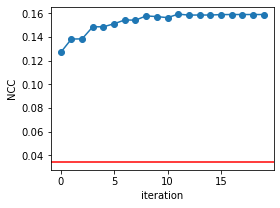

In [232]:
img_de,z_de,ncc_list,vec_field_smooth_list = iterive_non_rigid.learn_and_apply_deformable(im1_happy,nd2_f,vec_ds)

In [233]:
ncc_list[-1]

1.588058973925717e-01

# triptych as the summary plot. 

WARNING - 2022-02-26 18:54:28,946 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - 2022-02-26 18:54:29,287 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - 2022-02-26 18:54:29,901 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


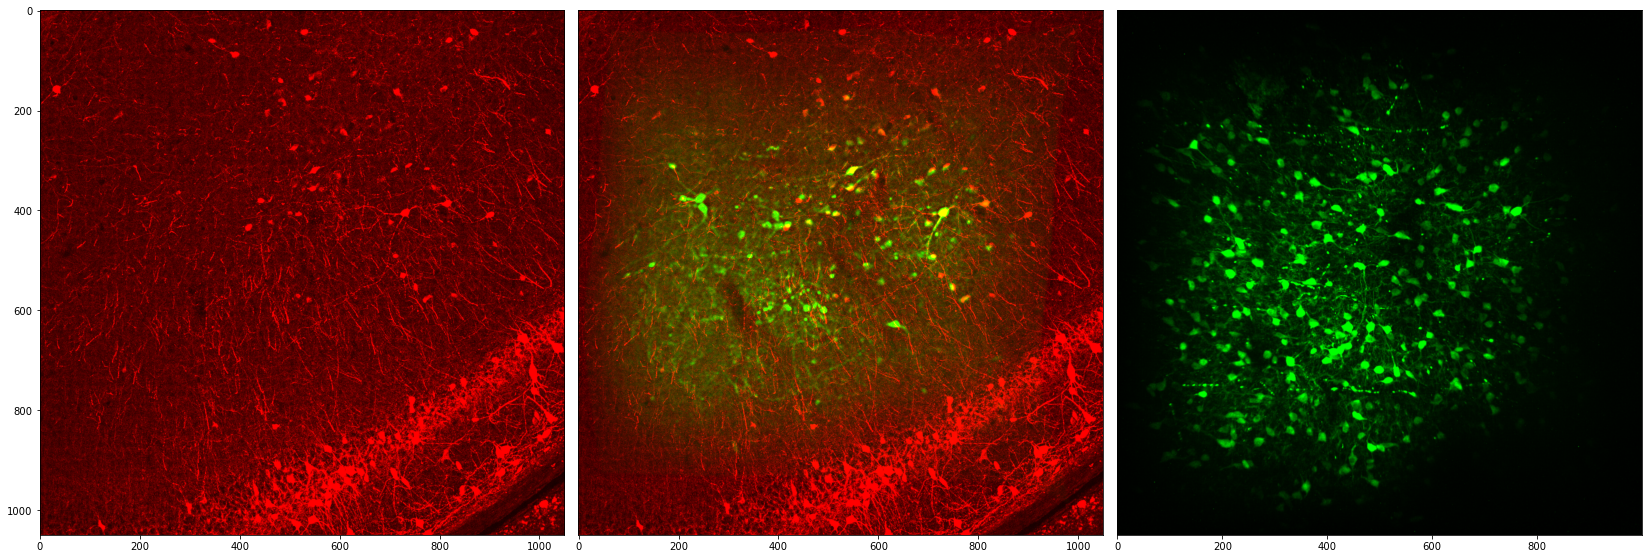

In [239]:
scl_1 =0.03
scl_2 =0.1
plt.figure(figsize = (23,11))
plt.subplot(1,3,1)
plt.imshow(gray2RGB(nd2_f, col='r',scl = scl_1) )
plt.subplot(1,3,2)
plt.imshow(gray2RGB(nd2_f, col='r',scl = scl_1) + 
           gray2RGB(z_de, col = 'g', scl = scl_2))
plt.yticks([])
plt.subplot(1,3,3)
plt.imshow(gray2RGB(z_f, col = 'g', scl = scl_2))
plt.yticks([])
plt.tight_layout()

In [235]:
sah_id, slice_id, 

('030', 6)

WARNING - 2022-02-26 18:05:52,678 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - 2022-02-26 18:05:53,026 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


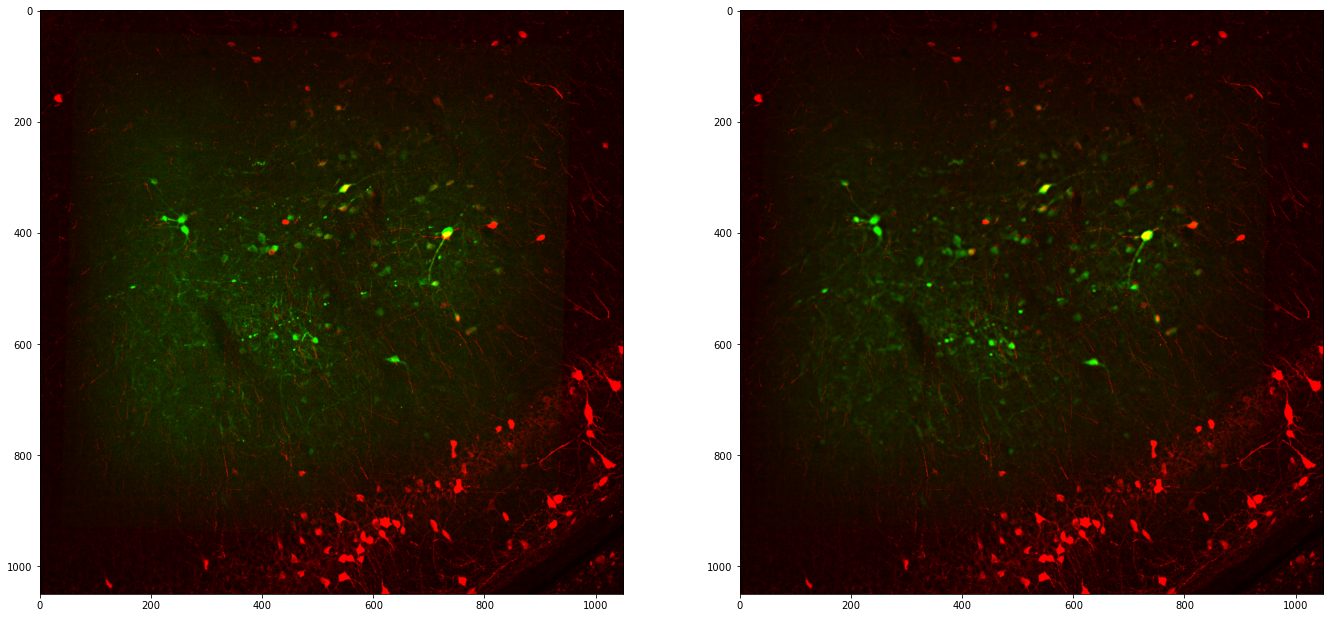

In [149]:
scl_1 =0.1
scl_2 =0.2
plt.figure(figsize = (23,11))
plt.subplot(1,2,1)
plt.imshow(gray2RGB(nd2_f, col='r',scl = scl_1) + 
           gray2RGB(im1_happy, col = 'g', scl = scl_2))
plt.subplot(1,2,2)
plt.imshow(gray2RGB(nd2_f, col='r',scl = scl_1) + 
           gray2RGB(z_de, col = 'g', scl = scl_2))


In [24]:
z_bi_de = apply_deformable_2_binary(im1_happy,im1_bi_happy,
                                    seg_cc_f_zstack,seg_cc_f_nd2,
                                    vec_ds,vec_field_smooth_list)



In [25]:
cc_im1,cc_im2,closest_pair,z_cent_new = count_cell_matching(z_bi_de, seg_cc_f_nd2)


***FOUND PAIRS:*** 47


In [27]:
z_cent_new.shape

(95, 3)

In [28]:
transform_rez = dict()
transform_rez['total_R']=total_R
transform_rez['total_shift']=total_shift
transform_rez['vec_field_smooth_list']=vec_field_smooth_list
transform_rez['z_matching_cent']= z_cent_new[closest_pair[:,1]]

# load the manual result

In [29]:
output_shape = z_de.shape
print(output_shape)
# assert(output_shape == (63, 1050, 1050))

(63, 1050, 1050)


In [30]:
df = pd.read_csv(f'/home/ubuntu/immunostaining/cellpose_{sah_id}/csvs/sah{sah_id}_adjusted_coords.csv')
df.columns =['X', 'Y', 'Z','type','ID']
df = df[['Z','Y','X','type','ID']]
manual_coord = df.values[:,:3].astype(float)
celllabel_man = df.values[:,-2]
cellID_man = (df.values[:,-1]).astype(int)
zrez,xrez,yrez =(3,1.5384615950848508, 1.5384615950848508)
manual_coord = manual_coord*np.array((zrez,yrez,xrez))
print(np.max(manual_coord,0),np.min(manual_coord,0))
temp = z_f.shape[1]-manual_coord[:,1].copy()
manual_coord[:,1] = temp
print(manual_coord[:,1].max(),manual_coord[:,1].min())  # 847.843351043208 172.80776176285656


[450.         766.52939883 763.30261702] [ 51.         152.15664895 190.23225531]
847.8433510460053 233.4706011723846


In [31]:
zslice = slice(430,440)
man_z_coord = manual_coord[:,0].copy()
coord_id = np.where([(z>zslice.start and z<=zslice.stop) for z in man_z_coord])[0]
man_z_coord

array([285., 285., 285., 285., 285., 411., 285., 288., 342., 360., 426.,
       420., 354., 339., 450., 438., 429., 429., 417., 414., 303., 330.,
       399., 210., 342., 408., 315., 432., 438., 426., 327.,  51., 375.,
       354., 303., 300., 330., 411., 426., 414., 417., 402., 363., 264.,
       420., 285., 213., 117., 405., 384., 363., 411., 306., 414., 417.,
       375., 225.])

## 1. get `warp_coord_f` (from original) and track which cells are there `kept_cellid`

In [32]:
from skimage.measure import regionprops
from skimage.transform import downscale_local_mean, rescale, warp

In [33]:
regionprops_f = regionprops(seg_cc_f_zstack)
orig_coord = np.array([np.around(prop.centroid).astype(int) for prop in regionprops_f])

In [35]:
z_bi_doubleicp = im1_bi_happy.copy()
z_bi_doubleicp_dsz = downscale_local_mean(z_bi_doubleicp, (vec_ds,vec_ds,vec_ds))>0
out = z_bi_doubleicp_dsz.copy()  # out is ds-ed
for i in range(len(vec_field_smooth_list)): 
    if i%10==0:
            print(f'iteration {i}...')
    vec_field_smooth = vec_field_smooth_list[i]
    assert((z_bi_doubleicp_dsz.shape == vec_field_smooth.shape[:-1]))

    shape = z_bi_doubleicp_dsz.shape
    mapz_base, mapx_base, mapy_base = np.meshgrid(np.arange(shape[0]),np.arange(shape[1]),np.arange(shape[2]), indexing='ij')
    mapz=mapz_base-vec_field_smooth[:,:,:,0]
    mapx=mapx_base-vec_field_smooth[:,:,:,1]
    mapy=mapy_base-vec_field_smooth[:,:,:,2]
    out = warp(out,np.array((mapz,mapx,mapy)), order = 0) # ds-ed        
z_bi_de = rescale(out,(vec_ds,vec_ds,vec_ds), order = 0)


iteration 0...
iteration 10...


In [36]:
doubleicp_coord = orig_coord@total_R+total_shift
zslice = slice(0-20,z_bi_doubleicp.shape[0]+20)
doubleicp_z_coord = doubleicp_coord[:,0].copy()
coord_id = np.where([(z>zslice.start and z<=zslice.stop) for z in doubleicp_z_coord])[0]
warp_coord = np.zeros_like(doubleicp_coord)

for c in (range(doubleicp_coord.shape[0])):
    if c in coord_id:
        loc = np.around(doubleicp_coord[c]/vec_ds).astype(int)
        loc = np.clip(loc,1,np.array((z_bi_doubleicp_dsz.shape))-2)
        bi_img = np.zeros_like(z_bi_doubleicp_dsz, dtype='bool')
        bi_img[loc[0]-1:loc[0]+2,loc[1]-1:loc[1]+2,loc[2]-1:loc[2]+2]=True
        out = bi_img.copy()  # out is ds-ed
        for i in range(len(vec_field_smooth_list)): 
            vec_field_smooth = vec_field_smooth_list[i]
            shape = bi_img.shape
            mapz_base, mapx_base, mapy_base = np.meshgrid(np.arange(shape[0]),np.arange(shape[1]),np.arange(shape[2]), indexing='ij')
            mapz=mapz_base-vec_field_smooth[:,:,:,0]
            mapx=mapx_base-vec_field_smooth[:,:,:,1]
            mapy=mapy_base-vec_field_smooth[:,:,:,2]
            out = warp(out,np.array((mapz,mapx,mapy)), order = 0) # ds-ed    
        warp_loc = np.mean((np.array(np.where(out)).T),0)
        warp_coord[c] = vec_ds*warp_loc
        

/home/ubuntu/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [37]:
vec_ds

3

In [38]:
warp_coord_f = []
kept_cellid = []
for c,loc in enumerate(warp_coord):
    if (loc==0).all() or np.isnan(loc).sum()==3:
        continue;
    else:
        warp_coord_f.append(loc)
        kept_cellid.append(c)
warp_coord_f = np.array(warp_coord_f)

In [39]:
len(kept_cellid)

78

## 2. `all_warped_matched`: which of `warp_coord_f` is within `z_matching_cent`
- we actually expect to see all `z_matching_cent` has the matching in `warp_coord_f`.
- note that each of `warp_coord_f` can be tracked back using `kept_cellid`}

In [40]:
z_matching_cent = transform_rez['z_matching_cent']
warp_coord_f.shape, z_matching_cent.shape

((78, 3), (47, 3))

In [41]:
import scipy.spatial

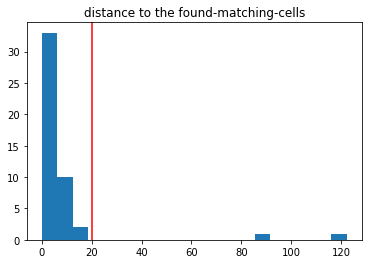

In [42]:
dst_mathes = scipy.spatial.distance.cdist(z_matching_cent,warp_coord_f)
plt.hist(np.min(dst_mathes, 1), bins = 20);
plt.axvline(20, color='red')
plt.title('distance to the found-matching-cells');

In [43]:
dst_mathes.shape

(47, 78)

In [44]:
all_warped_matched = []
for i,j in enumerate(np.argmin(dst_mathes,1)):
    # i is z_matching_cent ID, j is warp_coord_f ID
    if dst_mathes[i,j]<=20:
        all_warped_matched.append(j)
print(all_warped_matched)        

[4, 5, 20, 15, 26, 18, 6, 9, 30, 29, 34, 10, 35, 42, 23, 43, 37, 38, 50, 31, 53, 24, 60, 62, 17, 21, 70, 67, 16, 27, 39, 66, 49, 47, 68, 45, 69, 52, 12, 14, 56, 74, 65, 25, 33]


In [45]:
warp_coord_f[all_warped_matched].shape,z_matching_cent.shape # this is the 

((45, 3), (47, 3))

In [46]:
kept_cellid # from the original_coord, which of them are within this transformed regions

print('these are the original z coordinate region from teh original that we should be looking at!')
z_to_lookat = slice(np.min(np.array([orig_coord[m] for m in kept_cellid])[:,0]), np.max(np.array([orig_coord[m] for m in kept_cellid])[:,0]))
print(z_to_lookat)


these are the original z coordinate region from teh original that we should be looking at!
slice(302, 442, None)


## 3. from `all_warped_matched`, find back the cellposeID, get the orginal of matchings -- `orig_coord_matched`
- also save `all_warped_matched_origID` -- which of the original cellposeID is matched. 
- which means, `orig_coord[all_warped_matched_origID] == orig_coord_matched`
- also `orig_coord[kept_cellid]` -- these are all the cells in this z-slcies (either matched or not)

In [47]:
max(all_warped_matched)

74

In [48]:

all_warped_matched_origID = np.array([kept_cellid[m] for m in all_warped_matched])
orig_coord_matched = orig_coord[all_warped_matched_origID]

## 4. manual coord, in this region (by finding the small distance to the `orig_coord_matched`

In [49]:
np.max(orig_coord_matched,0), np.min(orig_coord_matched,0)

(array([434, 849, 880]), array([338, 119, 135]))

In [50]:
np.max(manual_coord, 0), np.min(manual_coord, 0)

(array([450.        , 847.84335105, 763.30261702]),
 array([ 51.        , 233.47060117, 190.23225531]))

In [51]:
man_z_coord = manual_coord[:,0].copy()
man_coord_id = np.where([(z>z_to_lookat.start and z<=z_to_lookat.stop) for z in man_z_coord])[0]

In [52]:
len(kept_cellid)

78

In [53]:
dst = scipy.spatial.distance.cdist(manual_coord,orig_coord_matched)

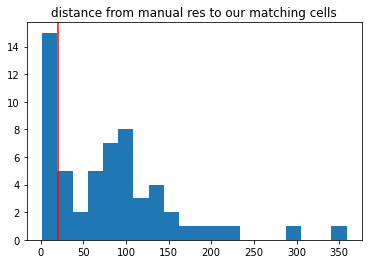

In [54]:
plt.hist(np.min(dst, 1), bins = 20);
plt.axvline(20, color='red')
plt.title('distance from manual res to our matching cells');

In [55]:
cellpair=[]
for i,j in enumerate(np.argmin(dst,1)):
    # i is manual ID, j is cellpose ID
    if dst[i,j]<=20:
        cellpair.append((i,all_warped_matched_origID[j]))
        
cellpair = np.array(cellpair)
print(cellpair.shape)

(15, 2)


In [56]:
cellpair

array([[ 11, 260],
       [ 15, 322],
       [ 16, 313],
       [ 18, 310],
       [ 19, 251],
       [ 22, 258],
       [ 27, 303],
       [ 29, 268],
       [ 32, 219],
       [ 37, 276],
       [ 42, 198],
       [ 44, 314],
       [ 48, 284],
       [ 49, 239],
       [ 54, 267]])

In [57]:
# confirm!!!!
(orig_coord[all_warped_matched_origID] == orig_coord_matched).all()

True

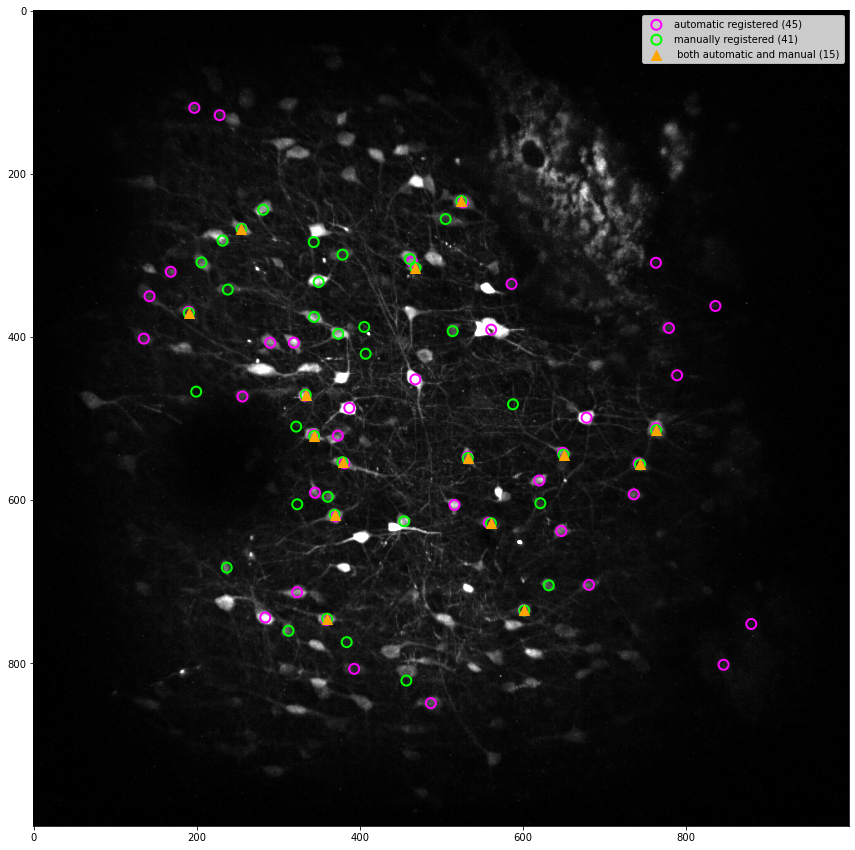

In [58]:
# zslice = slice(orig_coord[kept_cellid][:,0].min(),orig_coord[kept_cellid][:,0].max())
zslice = slice(np.min(orig_coord[cellpair[:,1],0]),np.max(orig_coord[cellpair[:,1],0]))
s = 100
plt.figure(figsize = (15,15))
plt.imshow(np.max(z_f[zslice],0), vmax=z_f[zslice].max()*.2, cmap='gray')
plt.scatter(orig_coord_matched[:,2],orig_coord_matched[:,1],
            s=s,facecolors='none', edgecolors='magenta', linewidth=2, label = f'automatic registered ({len(orig_coord_matched)})')
plt.scatter(manual_coord[man_coord_id,2], manual_coord[man_coord_id,1], 
            s=s, facecolors='none', edgecolors='lime', linewidth=2, label = f'manually registered ({len(man_coord_id)})')
plt.scatter(manual_coord[cellpair[:,0],2], manual_coord[cellpair[:,0],1], 
            s=s, marker='^', color='orange', label = f' both automatic and manual ({len(cellpair)})')
plt.legend()

In [59]:
print("this is manualcoord transformed:", warp_coord[cellpair[:,1]].shape) # 
print("this is all the matched cells transformed:", z_matching_cent.shape)

this is manualcoord transformed: (15, 3)
this is all the matched cells transformed: (47, 3)


### map the manula matching result to the transformed. 

In [60]:
man_doubleicp_coord = manual_coord@total_R+total_shift

warp_coord_man = []

for c in (man_coord_id):
    loc = np.around(man_doubleicp_coord[c]/vec_ds).astype(int)
    loc = np.clip(loc,1,np.array((z_bi_doubleicp_dsz.shape))-2)
    bi_img = np.zeros_like(z_bi_doubleicp_dsz, dtype='bool')
    bi_img[loc[0]-1:loc[0]+2,loc[1]-1:loc[1]+2,loc[2]-1:loc[2]+2]=True
    out = bi_img.copy()  # out is ds-ed
    for i in range(len(vec_field_smooth_list)): 
        vec_field_smooth = vec_field_smooth_list[i]
        shape = bi_img.shape
        mapz_base, mapx_base, mapy_base = np.meshgrid(np.arange(shape[0]),np.arange(shape[1]),np.arange(shape[2]), indexing='ij')
        mapz=mapz_base-vec_field_smooth[:,:,:,0]
        mapx=mapx_base-vec_field_smooth[:,:,:,1]
        mapy=mapy_base-vec_field_smooth[:,:,:,2]
        out = warp(out,np.array((mapz,mapx,mapy)), order = 0) # ds-ed    
    warp_loc = np.mean((np.array(np.where(out)).T),0)
    warp_coord_man.append(vec_ds*warp_loc)
warp_coord_man = np.array(warp_coord_man)



WARNING - 2022-02-26 16:01:32,973 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


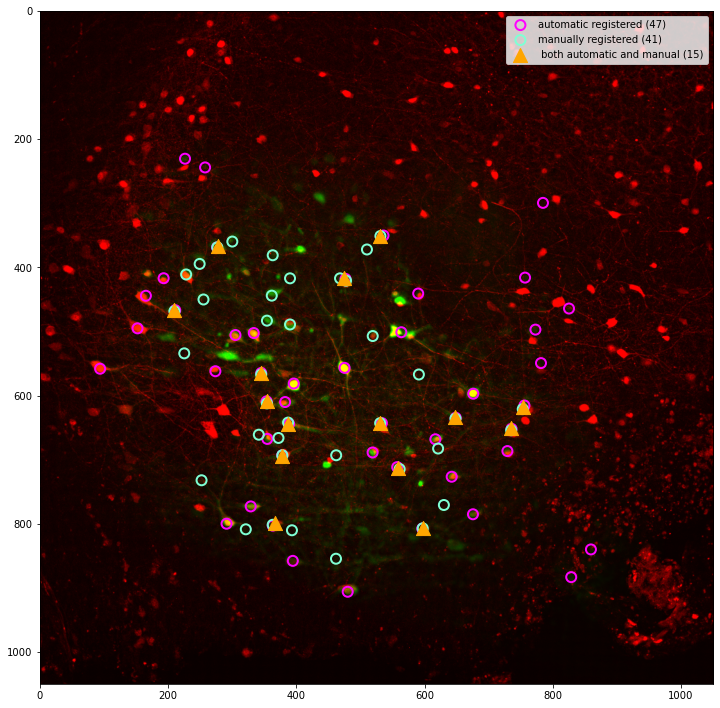

In [61]:
zslice = slice(np.min(orig_coord[cellpair[:,1],0]),np.max(orig_coord[cellpair[:,1],0]))
s = 100
plt.figure(figsize = (10,10))
scl_1 = 0.2
scl_2 = 0.4
# plt.subplot(1,2,2)
plt.imshow(gray2RGB(nd2_f, col = 'r', scl=scl_1)+gray2RGB(z_de, col = 'g',scl=scl_2))
plt.scatter(z_matching_cent[:,2],z_matching_cent[:,1], 
            s=s,facecolors='none', edgecolors='magenta', linewidth=2, label = f'automatic registered ({len(z_matching_cent)})')
plt.scatter(warp_coord_man[:,2], warp_coord_man[:,1], 
            s=s, facecolors='none', edgecolors='aquamarine', linewidth=2, label = f'manually registered ({len(man_coord_id)})')
plt.scatter(warp_coord[cellpair[:,1]][:,2],warp_coord[cellpair[:,1]][:,1], 
            s=2*s, marker='^', color='orange', label = f' both automatic and manual ({len(cellpair)})')
plt.legend()
plt.tight_layout()

In [62]:
sah_id, slice_id

('031', 3)

# only for sah031 slice3


In [63]:
import matplotlib.patches as patches

WARNING - 2022-02-26 16:28:01,983 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1049.5, 1049.5, -0.5)

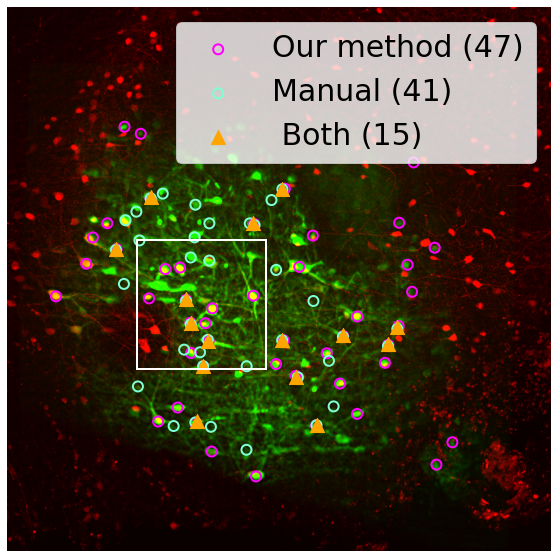

In [66]:
xslice = slice(450,700)
yslice = slice(250,500)


fs = 30
zslice = slice(np.min(orig_coord[cellpair[:,1],0]),np.max(orig_coord[cellpair[:,1],0]))
s = 100

scl_1 = 0.2
scl_2 = 0.1
plt.figure(figsize = (10,10))
plt.imshow(gray2RGB(nd2_f, col = 'r', scl=scl_1)+gray2RGB(z_de, col = 'g',scl=scl_2))
plt.scatter(z_matching_cent[:,2],z_matching_cent[:,1], 
            s=s,facecolors='none', edgecolors='magenta', linewidth=2, label = f'Our method ({len(z_matching_cent)})')
plt.scatter(warp_coord_man[:,2], warp_coord_man[:,1], 
            s=s, facecolors='none', edgecolors='aquamarine', linewidth=2, label = f'Manual ({len(man_coord_id)})')
plt.scatter(warp_coord[cellpair[:,1]][:,2],warp_coord[cellpair[:,1]][:,1], 
            s=2*s, marker='^', color='orange', label = f' Both ({len(cellpair)})')


plt.legend(prop={'size': fs})

rect = patches.Rectangle((yslice.start, xslice.start), yslice.stop-yslice.start-1, xslice.stop-xslice.start-1, 
                         linewidth=2, edgecolor='white', facecolor='none')

# Add the patch to the Axes
plt.gca().add_patch(rect)
plt.axis('off')

WARNING - 2022-02-26 16:28:22,052 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(0.0, 249.0, 249.0, 0.0)

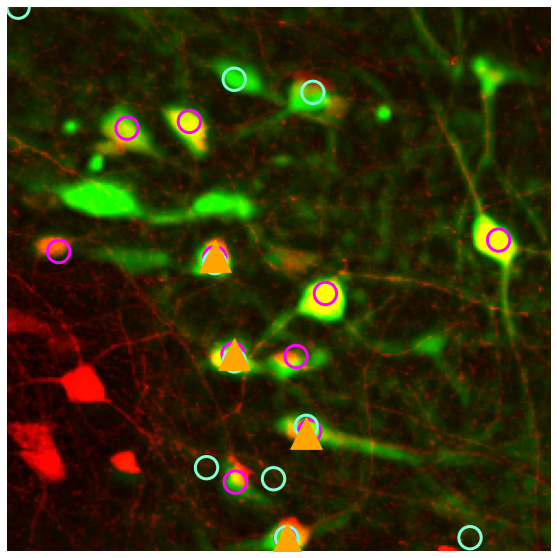

In [68]:
s =500
plt.figure(figsize = (10,10))

plt.imshow(gray2RGB(nd2_f[:,xslice,yslice], col = 'r', scl=0.3)+
           gray2RGB(z_de[:,xslice,yslice], col = 'g',scl=0.3))
plt.scatter(z_matching_cent[:,2]-yslice.start,z_matching_cent[:,1]-xslice.start, 
            s=s,facecolors='none', edgecolors='magenta', linewidth=3, label = f'automaticlly registered')
plt.scatter(warp_coord_man[:,2]-yslice.start, warp_coord_man[:,1]-xslice.start,
            s=s, facecolors='none', edgecolors='aquamarine', linewidth=3, label = f'manually registered ({len(man_coord_id)})')
plt.scatter(warp_coord[cellpair[:,1]][:,2]-yslice.start,warp_coord[cellpair[:,1]][:,1]-xslice.start, 
            s=2*s, marker='^', color='orange', label = f' both automatic and manual ({len(cellpair)})')
            
plt.xlim(0,yslice.stop-yslice.start-1)
plt.ylim(xslice.stop-xslice.start-1,0)
plt.axis('off')